# Introduction

<font color='midnightblue'>This notebook is a continuation to the "eda.ipynb" notebook, at the end of which a ML problem was formulated. This notebook attempts to build a predictive model to classify whether a major delay is likely to happen and the bus rider should try to find an alternative route. </font>

# Import Libraries, Loading final data for modelling

In [1]:
# Import libraries
import os, sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import files from google drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
# Load paths, replace with your own path if you're developing locally
master_path = '/content/gdrive/My Drive/ColabNtb/ttc_delay'
with open(os.path.join(master_path, 'data/paths.json'), 'r') as json_file:
  paths = json.load(json_file)

Mounted at /content/gdrive


In [4]:
paths['model'] = master_path + '/model'

In [5]:
# Import custom utility functions
sys.path.append(paths['src'])
#from utils import 

In [6]:
# Load final
df = pd.read_csv(os.path.join(paths['final/bus'], 'bus.csv'), index_col=0)
df.head()

,incident,direction,year,month,dayofweek,hour,severity,location,route,vehicle,wait
0,Mechanical,e,2014,1,2,0,Small,york mills station,95,1734,1
1,General Delay,both,2014,1,2,0,Major,entire,102,8110,0
2,Mechanical,w,2014,1,2,1,Small,lawrence warden,54,7478,1
3,Emergency Services,n,2014,1,2,1,Small,kipling station,112,8084,1
4,Investigation,n,2014,1,2,1,Small,vp ellesmere,24,7843,1


In [7]:
# Check class balance
df.wait.value_counts()

1    359128
0     43711
Name: wait, dtype: int64

<font color='midnightblue'>We have high imbalance that might affect the model's ability to focus on distinguishing the majority from minority class so we need to find a way to address that (Over-sampling, Under-sampling). For now, we will adjust class_weight in our classifier to give more weights to minority classes. </font>

In [8]:
# Import sklearn framework
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, f1_score, confusion_matrix, classification_report, roc_auc_score, plot_roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import ClusterCentroids
import pickle

In [9]:
# Define an evaluation function:
def evaluate(clf, Xtest, ytest):
  """ Run evaluation on a particular classifier
  ARGS:
    clf - scikitlearn model object
    Xtest (df) - the testing features
    ytest (array-like) - the testing labels
  Return prints of:
    Testing accuracy to identify overfitting
    AUC score to determine model's disriminative strength
    F1 Macro Score as a measure of how well the model predict minority class
    Classification report to see class specific precision, recall and f1
    Confusion matrix
    ROC_curve """

  print("Accuracy on test data:     {:.3f}".format(accuracy_score(ytest, clf.predict(Xtest))))
  try:
    print("AUC score     {:.3f}".format(roc_auc_score(ytest, clf.predict_proba(Xtest)[:, 1])))
  except:
    pass
  print("F1 macro score     {:.3f}".format(f1_score(ytest, clf.predict(Xtest), average='macro')))
  print(classification_report(ytest, clf.predict(Xtest)))
  print(confusion_matrix(ytest, clf.predict(Xtest)))
  tn, fp, fn, tp = confusion_matrix(ytest, clf.predict(Xtest)).ravel()
  print(f'\n Number of times:')
  print(f'Model predicted leave, and should leave: {tn}')
  print(f'Model predicted wait, and should leave: {fp}')
  print(f'Model predicted leave, and should wait: {fp}')
  print(f'Model predicted wait, and should wait: {tp}')
  plot_roc_curve(clf, Xtest, ytest)

In [10]:
# Initiate a dictionary to store classifiers
clf_dict = {}

In [11]:
# Convert all features to categorical
for feat in df.columns:
  df[feat] = df[feat].astype('category')

In [12]:
# Get X, y
X = pd.get_dummies(df.drop(['wait', 'severity', 'location', 'vehicle'], axis = 1), sparse=True)
y = df.wait
indices = df.index

<font color='midnightblue'>We will drop location and vehicle for now due to their throng of categories. </font>

In [13]:
# Split train and test set
Xtrain, Xtest, ytrain, ytest, itrain, itest = train_test_split(X, y, indices, train_size = 0.8, random_state = 42)

# Baseline Model (Logistic Regression)

<font color='midnightblue'>We start with a logistic regression model to establish the baseline and any possible behavior of models on the data.</font>

In [14]:
# Fit a simple Logistic Regression model
clf = LogisticRegression(solver = 'lbfgs', C=1, class_weight='balanced')
clf.fit(Xtrain, ytrain)

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy on test data:     0.833
AUC score     0.901
F1 macro score     0.703
              precision    recall  f1-score   support

           0       0.37      0.80      0.51      8678
           1       0.97      0.84      0.90     71890

    accuracy                           0.83     80568
   macro avg       0.67      0.82      0.70     80568
weighted avg       0.91      0.83      0.86     80568

[[ 6907  1771]
 [11688 60202]]

 Number of times:
Model predicted leave, and should leave: 6907
Model predicted wait, and should leave: 1771
Model predicted leave, and should wait: 1771
Model predicted wait, and should wait: 60202


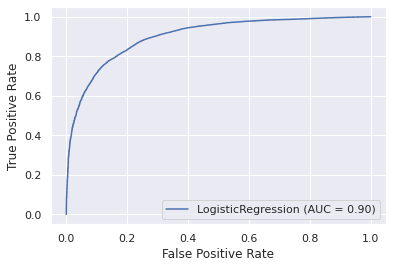

In [15]:
# Evaluate
evaluate(clf, Xtest, ytest)

In [16]:
filename = 'lr.sav'
pickle.dump(clf, open(os.path.join(paths['model'], filename), 'wb'))
clf_dict['lr'] = clf

<font color='midnightblue'>The baseline already did quite a good job with a high AUC score. One thing to note here is that the model is really struggling with the minority class. It was only able to find most of the times a rider needs to find alternative route but at the cost of low precision. </font>

<font color='midnightblue'>Next, we will experiment with different classifiers. The intuition is that tree-based classifiers will do well due to the fact that most of the variables are categorical. We can also try Support Vector Classifiers and a generative model Naive Bayes. My experience with NLP tells me that Naive Bayes will work well on a sparse dataset like this. </font>

# Tree-based techniques

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

## Decision Tree

In [18]:
clf = DecisionTreeClassifier(random_state=42, class_weight='balanced')
clf.fit(Xtrain,ytrain)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

Accuracy on test data:     0.899
AUC score     0.764
F1 macro score     0.750
              precision    recall  f1-score   support

           0       0.53      0.59      0.56      8678
           1       0.95      0.94      0.94     71890

    accuracy                           0.90     80568
   macro avg       0.74      0.76      0.75     80568
weighted avg       0.90      0.90      0.90     80568

[[ 5122  3556]
 [ 4613 67277]]

 Number of times:
Model predicted leave, and should leave: 5122
Model predicted wait, and should leave: 3556
Model predicted leave, and should wait: 3556
Model predicted wait, and should wait: 67277


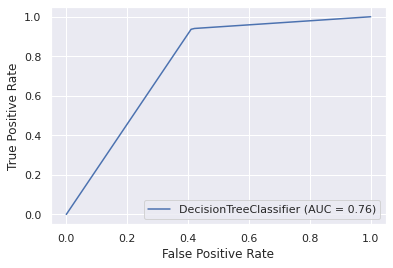

In [19]:
# Evaluate
evaluate(clf, Xtest, ytest)

In [20]:
filename = 'dt.sav'
pickle.dump(clf, open(os.path.join(paths['model'], filename), 'wb'))
clf_dict['dt'] = clf

## Random Forest

In [21]:
clf = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=42, class_weight='balanced')
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Accuracy on test data:     0.995
AUC score     1.000
F1 macro score     0.987
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      8678
           1       1.00      0.99      1.00     71890

    accuracy                           1.00     80568
   macro avg       0.98      1.00      0.99     80568
weighted avg       1.00      1.00      1.00     80568

[[ 8659    19]
 [  379 71511]]

 Number of times:
Model predicted leave, and should leave: 8659
Model predicted wait, and should leave: 19
Model predicted leave, and should wait: 19
Model predicted wait, and should wait: 71511


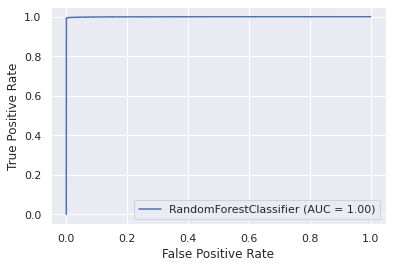

In [22]:
# Evaluate
evaluate(clf, Xtest, ytest)

In [23]:
filename = 'rf.sav'
pickle.dump(clf, open(os.path.join(paths['model'], filename), 'wb'))
clf_dict['rf'] = clf

## Gradient Boosted Trees

In [24]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_features='sqrt', random_state=42)
clf.fit(X, y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=1.0, loss='deviance', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Accuracy on test data:     0.911
AUC score     0.796
F1 macro score     0.711
              precision    recall  f1-score   support

           0       0.66      0.37      0.47      8678
           1       0.93      0.98      0.95     71890

    accuracy                           0.91     80568
   macro avg       0.79      0.67      0.71     80568
weighted avg       0.90      0.91      0.90     80568

[[ 3169  5509]
 [ 1631 70259]]

 Number of times:
Model predicted leave, and should leave: 3169
Model predicted wait, and should leave: 5509
Model predicted leave, and should wait: 5509
Model predicted wait, and should wait: 70259


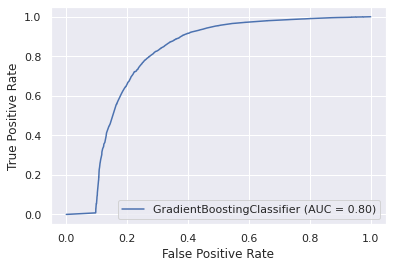

In [25]:
# Evaluate
evaluate(clf, Xtest, ytest)

In [26]:
filename = 'gbt.sav'
pickle.dump(clf, open(os.path.join(paths['model'], filename), 'wb'))
clf_dict['gbt'] = clf

# Support Vector Machines

In [27]:
from sklearn.svm import LinearSVC, SVC

In [29]:
clf = LinearSVC(C=1, class_weight='balanced')
clf.fit(X, y)

LinearSVC(C=1, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Accuracy on test data:     0.837
F1 macro score     0.706
              precision    recall  f1-score   support

           0       0.38      0.79      0.51      8678
           1       0.97      0.84      0.90     71890

    accuracy                           0.84     80568
   macro avg       0.67      0.82      0.71     80568
weighted avg       0.91      0.84      0.86     80568

[[ 6856  1822]
 [11343 60547]]

 Number of times:
Model predicted leave, and should leave: 6856
Model predicted wait, and should leave: 1822
Model predicted leave, and should wait: 1822
Model predicted wait, and should wait: 60547


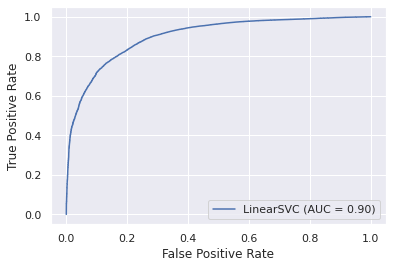

In [30]:
# Evaluate
evaluate(clf, Xtest, ytest)

In [31]:
filename = 'svc.sav'
pickle.dump(clf, open(os.path.join(paths['model'], filename), 'wb'))
clf_dict['svc'] = clf

In [32]:
from sklearn.linear_model import SGDClassifier

In [33]:
clf = SGDClassifier()
clf.fit(X, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Accuracy on test data:     0.916
F1 macro score     0.735
              precision    recall  f1-score   support

           0       0.68      0.42      0.52      8678
           1       0.93      0.98      0.95     71890

    accuracy                           0.92     80568
   macro avg       0.81      0.70      0.74     80568
weighted avg       0.91      0.92      0.91     80568

[[ 3623  5055]
 [ 1715 70175]]

 Number of times:
Model predicted leave, and should leave: 3623
Model predicted wait, and should leave: 5055
Model predicted leave, and should wait: 5055
Model predicted wait, and should wait: 70175


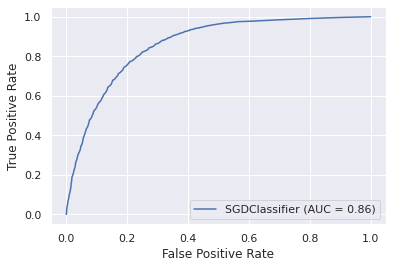

In [34]:
# Evaluate
evaluate(clf, Xtest, ytest)

In [35]:
filename = 'sgd.sav'
pickle.dump(clf, open(os.path.join(paths['model'], filename), 'wb'))
clf_dict['sgd'] = clf

# Naive Bayes

In [36]:
from sklearn.naive_bayes import MultinomialNB

In [37]:
clf = MultinomialNB(alpha=0.001)
clf.fit(X, y)

MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True)

Accuracy on test data:     0.914
AUC score     0.891
F1 macro score     0.722
              precision    recall  f1-score   support

           0       0.68      0.39      0.49      8678
           1       0.93      0.98      0.95     71890

    accuracy                           0.91     80568
   macro avg       0.80      0.68      0.72     80568
weighted avg       0.90      0.91      0.90     80568

[[ 3344  5334]
 [ 1605 70285]]

 Number of times:
Model predicted leave, and should leave: 3344
Model predicted wait, and should leave: 5334
Model predicted leave, and should wait: 5334
Model predicted wait, and should wait: 70285


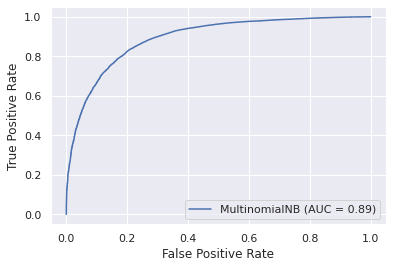

In [38]:
# Evaluate
evaluate(clf, Xtest, ytest)

In [39]:
filename = 'nb.sav'
pickle.dump(clf, open(os.path.join(paths['model'], filename), 'wb'))
clf_dict['nb'] = clf

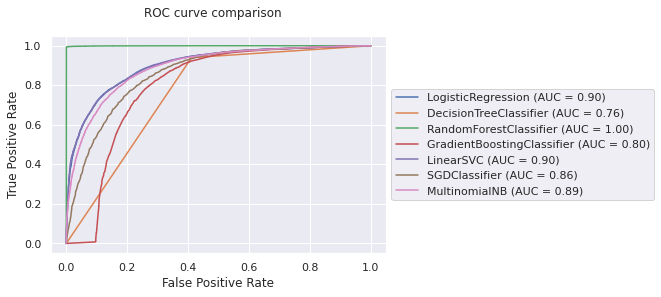

In [45]:
# Plot all model ROC for comparison
disp = plot_roc_curve(clf_dict['lr'], Xtest, ytest)
for key, value in clf_dict.items():
  if key != 'lr':
    disp = plot_roc_curve(value, Xtest, ytest, ax=disp.ax_)
disp.figure_.suptitle("ROC curve comparison")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

<font color='midnightblue'>We can see random forest doing really well with barely any missclassification. It makes sense that random forest would be a great classifier for this task as it is able to detect non-linearity in high dimensional data. We should nevertheless sanity check it's results. SVC, LR baseline and Naive Bayes also did very well and are potential winners. </font>

# Conclusion, Limitation & Future direction

<font color='midnightblue'>We are able to train a model with high AUC and accuracy to predict whether or not a bus delay will be severe and therefore enable bus riders to seek alternative routes. Due to the limited time of this assignment, there are many possible future expansion of the project.
- Currently, the project only utilizes Delay data. Other types of data can be incorporated to improve the product and find new ML business cases, such as weather data, bus-stop data and gps data. A product can be made, for example, where the user is given estimated fastest route based on their GPS location and walking characteristics.
- Limited computation and time has prevent k-fold cross validation and grid-search techniques. Hyper-parameter tuning and cross validation will be necessary to ensure generalization of the model. </font>